[INFO] loading dataset...
[]
[INFO] saving testing filenames...
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 122, 128)     147584    
________________________________________________________

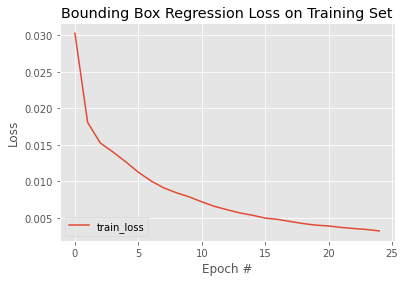

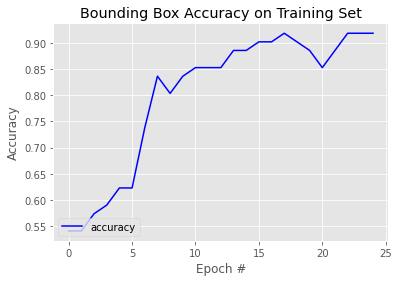

In [13]:
import os
import cv2
import config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from preprocess_data import read_image_as_array
from preprocess_data import load_train_dataset, load_val_dataset
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


def load_bb(csv, dir_bb):
    df = pd.read_csv(csv, sep=';').dropna()

    images = []
    boxes = []
    names = []
    count = 0

    filenames = df['File_name'].tolist()
    bb = df['Bounding_boxes'].tolist()
    # axis = df['Measurement_coordinates'].tolist()

    for row in bb:
        name = filenames[count]
        row = row.split(',')
        (startX, startY, endX, endY) = row 

        imagePath = os.path.sep.join([dir_bb, name])
        image = cv2.imread(imagePath)
        if image is None:
            continue
        (h, w) = image.shape[:2]

        # scale the bounding box coordinates relative to the spatial
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h

        # load the image and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        images.append(image)
        boxes.append((startX, startY, endX, endY))
        names.append(name)

        count += 1

    return images, boxes, names


def train():
    print("[INFO] loading dataset...")
    image_t, box_t, filenames_t = load_bb(config.train_csv, config.train_dir_bb)
    image_v, box_v, filenames_v = load_bb(config.val_csv, config.val_dir_bb)

    # convert the image and the box to NumPy arrays
    image_t = np.array(image_t, dtype='float32') / 255.0
    box_t = np.array(box_t, dtype='float32')
    image_v = np.array(image_v, dtype='float32') / 255.0
    box_v = np.array(box_v, dtype='float32')

    print("[INFO] saving testing filenames...")
    f = open(config.test_image, 'w')
    f.write('\n'.join(filenames_v))
    f.close()

    # load the VGG16 network
    vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 244, 3)))
    #resNet = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 244, 3))
    
    vgg.trainable = False

    flatten = vgg.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(128, activation='relu')(flatten)
    bboxHead = Dense(64, activation='relu')(bboxHead)
    bboxHead = Dense(32, activation='relu')(bboxHead)
    bboxHead = Dense(4, activation='sigmoid')(bboxHead)

    model = Model(inputs=vgg.input, outputs=bboxHead)
 

    # initialize the optimizer, compile the model and show the model
    opt = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    print(model.summary())

    # train the network for bounding box regression
    print("[INFO] training bounding box regress...")
    history = model.fit(image_t, box_t, validation_data=(image_v, box_v), batch_size=32, epochs=25, verbose=1)

    print("[INFO] saving object detector model...")
    model.save(config.model_detector, save_format='h5')

    return history


if __name__ == "__main__":
    H = train()

    N = 25
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
    plt.title('Bounding Box Regression Loss on Training Set')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='lower left')
    plt.savefig(config.plot_path_loss)
    
    plt.figure()    
    plt.plot(np.arange(0, N), H.history['accuracy'], label='accuracy', color='blue')
    plt.title('Bounding Box Accuracy on Training Set')
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower left')
    plt.savefig(config.plot_path_acc)